# Deep-Learning with Keras

#### Ugur URESIN, AI Engineer | Data Scientist
#### Mail: uresin.ugur@gmail.com

## Chapter 13. Timeseries Analysis with LSTM

#### Importing the Dataset

In [4]:
import os
data_dir = '/users/fchollet/Downloads/jena_climate'
data_dir = './data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

for word in header:
    print(word)

print("\nThe number of rows in the data:", len(lines))

"Date Time"
"p (mbar)"
"T (degC)"
"Tpot (K)"
"Tdew (degC)"
"rh (%)"
"VPmax (mbar)"
"VPact (mbar)"
"VPdef (mbar)"
"sh (g/kg)"
"H2OC (mmol/mol)"
"rho (g/m**3)"
"wv (m/s)"
"max. wv (m/s)"
"wd (deg)"

The number of rows in the data: 420451


#### Parsing the Data (Converting to Numpy)

In [5]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

#### Plotting the Temperature Timeseries

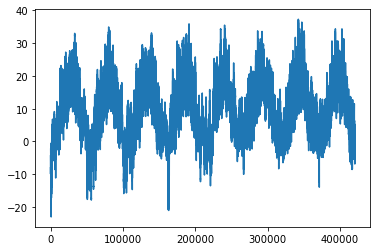

In [6]:
from matplotlib import pyplot as plt
temp = float_data[:, 1]  #<1> temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

#### Plotting the first 10 days of the temperature timeseries

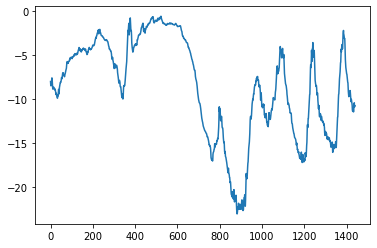

In [7]:
plt.plot(range(1440), temp[:1440])

#### Normalizing the Data

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

#### Generator yielding timeseries samples and their targets

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

#### Preparing the training, validation, and test generators

1. **lookback** = 720 (Observations will go back 5 days)
2. **steps** = 6 (Observations will be sampled at one data point per hour)
3. **delay** = 144 (Targets will be 24 hours in the future)

To get started, you need to do two things:

Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, temperature is typi- cally between -20 and +30, but atmospheric pressure, measured in mbar, is around 1,000). You’ll normalize each timeseries independently so that they all take small values on a similar scale.

Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, you’ll generate the samples on the fly using the original data.

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [11]:
#How many steps to draw from val_gen in order to see the entire validation set
val_steps = (300000 - 200001 - lookback)

#How many steps to draw from test_gen in order to see the entire test set
test_steps = (len(float_data) - 300001 - lookback)

#### Baseline Evaluation Approach: MAE
Before you start using black-box deep-learning models to solve the temperature- prediction problem, let’s try a simple, common-sense approach.  
It will serve as a sanity check, and it will establish a baseline that you’ll have to beat in order to demonstrate the usefulness of more-advanced machine-learning models.  
Such common-sense base- lines can be useful when you’re approaching a new problem for which there is no known solution (yet).  
A classic example is that of unbalanced classification tasks, where some classes are much more common than others.  
If your dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to the classification task is to always predict “A” when presented with a new sample.  
Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary baselines can prove surprisingly hard to beat.  

In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period.  
Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now.  

Let’s evaluate this approach, using the **mean absolute error (MAE)** metric:

In [12]:
def evaluate_naive_method():
    batch_maes = []
    
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    
    print(np.mean(batch_maes))

evaluate_naive_method()

0.28969941979609765


This yields an **MAE** of 0.29.  

Because the temperature data has been normalized to be centered on 0 and have a standard deviation of 1, this number isn’t immediately interpretable.  

It translates to an average absolute error of **0.29 × temperature_std degrees Celsius**: 2.57 ̊C.

In [13]:
# Converting the MAE back to a Celsius error
celsius_mae = 0.29 * std[1]
print(celsius_mae)

2.5672247338393395


#### A Basic ML Approach

In the same way that it’s useful to establish a common-sense baseline before trying machine-learning approaches, it’s useful to try simple, cheap machine-learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs.  

This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.  
The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers.  
Note the lack of activation function on the last Dense layer, which is typical for a regression problem.  
MAE is used as the loss.  
Because you evaluate on the exact same data and with the exact same metric you did with the common-sense approach, the results will be directly comparable.

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.
2021-09-26 11:38:16.276738: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-26 11:38:16.276916: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/20
500/500 [==============================] - 778s 2s/step - loss: 1.4414 - val_loss: 0.2491
Epoch 2/20
500/500 [==============================] - 786s 2s/step - loss: 0.5359 - val_loss: 0.1287
Epoch 3/20
500/500 [==============================] - 913s 2s/step - loss: 0.3416 - val_loss: 0.3852
Epoch 4/20
500/500 [==============================] - 877s 2s/step - loss: 0.2863 - val_loss: 0.2195
Epoch 5/20
500/500 [==============================] - 818s 2s/step - loss: 0.2655 - val_loss: 0.2633
Epoch 6/20
500/500 [==============================] - 746s 1s/step - loss: 0.2530 - val_loss: 0.1955
Epoch 7/20
500/500 [==============================] - 735s 1s/step - loss: 0.2455 - val_loss: 0.4695
Epoch 8/20
500/500 [==============================] - 737s 1s/step - loss: 0.2375 - val_loss: 0.6726
Epoch 9/20
500/500 [==============================] - 727s 1s/step - loss: 0.2315 - val_loss: 0.2915
Epoch 10/20
500/500 [==============================] - 850s 2s/step - loss: 0.2274 - val_lo

#### Visualizing the Results

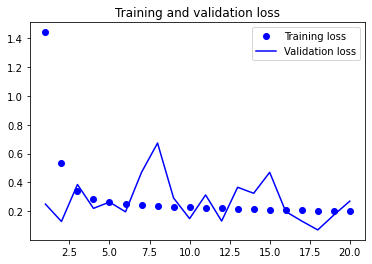

In [15]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Some of the **validation losses are close to the no-learning baseline**, but not reliably.  

This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform.  
Your common sense contains a lot of valuable information that a machine-learning model doesn’t have access to.  

You may wonder, if a simple, well-performing model exists to go from the data to the targets (the common-sense baseline), why doesn’t the model you’re training find it and improve on it?  
Because this simple solution isn’t what your training setup is looking for.  
The space of models in which you’re searching for a solution —that is, your hypothesis space— is the space of all possible two-layer networks with the configuration you defined.  
These networks are already fairly complicated.  
When you’re looking for a solution with a space of complicated models, the simple, well-performing baseline may be unlearnable, even if it’s technically part of the hypothesis space.  
That is a pretty sig- nificant limitation of machine learning in general: unless the learning algorithm is hardcoded to look for a specific kind of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

#### A First Recurrent Baseline Approach

The first fully connected approach didn’t do well, but that doesn’t mean machine learning isn’t applicable to this problem.  
The previous approach first flattened the timeseries, which removed the notion of time from the input data.  

Let’s instead look at the data as what it is: a sequence, where causality and order matter. You’ll try a recurrent-sequence processing model—it should be the perfect fit for such sequence data, precisely because it exploits the temporal ordering of data points, unlike the first approach.  

Instead of the LSTM layer introduced in the previous section, you’ll use the GRU layer, developed by Chung et al. in 2014.5 Gated recurrent unit (GRU) layers work using the same principle as LSTM, but they’re somewhat streamlined and thus cheaper to run (although they may not have as much representational power as LSTM). This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.

In [17]:
## Training and evaluating a GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
        
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
499/500 [============================>.] - ETA: 18s - loss: 0.3019

KeyboardInterrupt: 